# Stochastic Tree Implementation and Analysis

In [1]:
import pickle
import numpy as np
import random
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict

 ## TreeNode Class

Defines the structure of each node in the tree, including its value and children with associated transition probabilities.

In [2]:
class TreeNode:
    def __init__(self, value):
        """
        Initializes a TreeNode with a given value.

        Parameters:
        - value (int or float): The value of the node.
        """
        self.value = value
        self.children = []

    def add_child(self, child_node, probability):
        """
        Adds a child node with an associated transition probability.

        Parameters:
        - child_node (TreeNode): The child node to be added.
        - probability (float): The probability of transitioning to this child.
        """
        # It might be wise to write a check for sum proba = 1.
        self.children.append((child_node, probability))


## Building Specific Trees

This section includes functions to construct two predefined tree structures along with their associated transition probabilities. These trees are described in the paper: 

**"Nested Sinkhorn Divergence To Compute The Nested Distance"**  
by Alois Pichler and Michael Weinhardt.

In [3]:
def build_tree_1():

    # Root node
    tree_1_root = TreeNode(10)

    # Level 1
    node_10 = TreeNode(10)
    tree_1_root.add_child(node_10, 1.0)

    # Level 2
    node_12 = TreeNode(12)
    node_8 = TreeNode(8)
    node_10.add_child(node_12, 34 / 100)
    node_10.add_child(node_8, 66 / 100)

    # Level 3
    node_13 = TreeNode(13)
    node_10_level3 = TreeNode(10)
    node_12.add_child(node_13, 54 / 100)
    node_12.add_child(node_10_level3, 46 / 100)

    node_9 = TreeNode(9)
    node_6 = TreeNode(6)
    node_8.add_child(node_9, 24 / 100)
    node_8.add_child(node_6, 76 / 100)

    return tree_1_root

def build_tree_2():

    # Root node
    tree_2_root = TreeNode(10)

    # Level 1
    node_13 = TreeNode(13)
    node_7 = TreeNode(7)
    tree_2_root.add_child(node_13, 3 / 10)
    tree_2_root.add_child(node_7, 7 / 10)

    # Level 2
    node_14 = TreeNode(14)
    node_11 = TreeNode(11)
    node_13.add_child(node_14, 2 / 10)
    node_13.add_child(node_11, 8 / 10)

    node_8 = TreeNode(8)
    node_5 = TreeNode(5)
    node_7.add_child(node_8, 1 / 10)
    node_7.add_child(node_5, 9 / 10)

    # Level 3
    node_15 = TreeNode(15)
    node_14_self = TreeNode(14)
    node_13_level3 = TreeNode(13)
    node_14.add_child(node_15, 5 / 10)
    node_14.add_child(node_14_self, 1 / 10)
    node_14.add_child(node_13_level3, 4 / 10)

    node_12 = TreeNode(12)
    node_10_level3 = TreeNode(10)
    node_11.add_child(node_12, 6 / 10)
    node_11.add_child(node_10_level3, 4 / 10)

    node_9_level3 = TreeNode(9)
    node_7_level3 = TreeNode(7)
    node_8.add_child(node_9_level3, 4 / 10)
    node_8.add_child(node_7_level3, 6 / 10)

    node_6 = TreeNode(6)
    node_4 = TreeNode(4)
    node_5.add_child(node_6, 3 / 10)
    node_5.add_child(node_4, 7 / 10)

    return tree_2_root

## Extracting Sample Paths and Probabilities

This function traverses the tree from the root to all leaf nodes, recording each path and calculating its associated probability (weight). This is particularly useful as the code in:  

**"Computational Methods for Adapted Optimal Transport"**  
by Stephan Eckstein¹ and Gudmund Pammer  

treats input in that form.

In [4]:
def get_sample_paths(tree_root):
    """
    Extracts all possible paths from the root to the leaves of the tree
    along with their associated probabilities.

    Parameters:
    - tree_root (TreeNode): The root node of the tree.

    Returns:
    - tuple: A tuple containing:
        - paths_array (np.ndarray): 2D array where each row is a path.
        - probabilities_array (np.ndarray): 1D array of path probabilities.
    """
    paths = []
    probabilities = []

    def traverse(node, current_path, current_prob):
        """
        Recursively traverses the tree to collect paths and probabilities.

        Parameters:
        - node (TreeNode): The current node being traversed.
        - current_path (list): The path taken to reach the current node.
        - current_prob (float): The cumulative probability of the current path.
        """
        
        new_path = current_path + [node.value]

        if not node.children:
            paths.append(new_path)
            probabilities.append(current_prob)
            return

        for child, prob in node.children:
            traverse(child, new_path, current_prob * prob)

    # Initialize traversal from the root
    traverse(tree_root, [], 1.0)

    # Convert lists to NumPy arrays
    paths_array = np.array(paths)
    probabilities_array = np.array(probabilities)

    return [paths_array, probabilities_array]

def display_tree_data(paths_weights, tree_name):
    """
    Displays the paths and their associated probabilities for a given tree.

    Parameters:
    - paths_weights (tuple): A tuple containing paths and probabilities.
    - tree_name (str): The name of the tree for display purposes.
    """
    print(f"\n{tree_name} (Path and Weight Format):")
    print("Paths:")
    print(paths_weights[0])
    print("Weights:")
    print(paths_weights[1])

## Calculating Tree Depth

Determines the depth (height) of the tree, starting at `0` for the root node.

In [5]:
def get_depth(tree_root):
    """
    Calculates the depth (height) of the tree, starting at 0 for the root node.

    Parameters:
    - tree_root (TreeNode): The root node of the tree.

    Returns:
    - int: The depth of the tree.
    """
    if tree_root is None:
        return -1  # Assuming an empty tree has a depth of -1 (convenient for us)

    # If the node has no children, its depth is 0
    if not tree_root.children:
        return 0

    # Since all paths have the same depth, we can check just one path
    first_child, _ = tree_root.children[0]
    return 1 + get_depth(first_child)

## Visualization of Trees

This section provides functionality to visualize the stochastic tree using **NetworkX** and **Matplotlib**. The visualization includes:  
- Nodes  
- Edges with transition probabilities  
- Color-coding based on depth  

**Note:** This visualization is suitable only for small trees as it becomes very messy for larger trees.

In [6]:
def visualize_tree(tree_root, title="Tree Visualization"):
    """
    Visualizes the stochastic tree using NetworkX and Matplotlib.

    Parameters:
    - tree_root (TreeNode): Root node of the tree to visualize.
    - title (str): Title of the plot.
    """
    G = nx.DiGraph()
    node_labels = {}

    # Position dictionary
    pos = {}

    # Counter for unique node identifiers
    id_counter = defaultdict(int)

    # Dictionary to store depths of TreeNode objects
    depths = {}

    def assign_depths(node, current_depth=0):
        depths[node] = current_depth
        for child, _ in node.children:
            assign_depths(child, current_depth + 1)

    assign_depths(tree_root)

    # Function to add nodes and edges to the graph
    def add_edges(node, parent_name=None, x=0, y=0, dx=1.0):
        nonlocal G, pos, node_labels, id_counter

        # Assign a unique name to the node
        if parent_name is None:
            node_name = f"root_{node.value:.2f}"
        else:
            id_counter[parent_name] += 1
            node_name = f"{parent_name}_{id_counter[parent_name]}_{node.value:.2f}"

        # Assign position
        pos[node_name] = (x, y)
        node_labels[node_name] = f"{node.value:.2f}"

        # Add node to graph
        G.add_node(node_name)

        # If there's a parent, add an edge with the transition probability
        if parent_name is not None:
            parent_node = name_to_node[parent_name]
            # Find the child in parent's children to get the probability
            for child, prob in parent_node.children:
                if abs(child.value - node.value) < 1e-6:
                    G.add_edge(parent_name, node_name, weight=prob)
                    break

        # Map node name to TreeNode object for easy access
        name_to_node[node_name] = node

        # If the node has children, recursively add them
        if node.children:
            num_children = len(node.children)
            # Calculate horizontal spacing
            width = dx / num_children
            for i, (child, prob) in enumerate(node.children):
                child_x = x - dx/2 + i * width + width / 2
                child_y = y - 1
                add_edges(child, node_name, child_x, child_y, dx / 2)

    # Initialize mapping from node names to TreeNode objects
    name_to_node = {}

    # Start adding edges from the root
    add_edges(tree_root)

    # Map node names to their depths
    node_depths = {}
    for node_name in G.nodes():
        node = name_to_node.get(node_name, None)
        if node:
            node_depths[node_name] = depths.get(node, 0)
        else:
            node_depths[node_name] = 0

    # Define color map based on depth
    cmap = plt.get_cmap('viridis')
    max_depth = max(node_depths.values()) if node_depths else 1
    max_depth = max(max_depth, 1)  # Ensure max_depth is at least 1 to avoid division by zero
    node_colors = [cmap(depth / max_depth) for depth in node_depths.values()]

    # Create figure and axes
    fig, ax = plt.subplots(figsize=(12, 8))

    # Draw the graph on the specified axes
    nx.draw(
        G, pos,
        labels=node_labels,
        with_labels=True,
        node_size=800,
        node_color=node_colors,
        font_size=8,
        font_weight="bold",
        arrows=True,
        arrowstyle='-|>',
        arrowsize=10,
        ax=ax
    )

    # Add edge labels with probabilities
    edge_labels = {(u, v): f"{d['weight']:.2f}" for u, v, d in G.edges(data=True)}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=6, ax=ax)

    # Create a ScalarMappable and add a colorbar to the figure
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=max_depth))
    sm.set_array([])  # Only needed for older versions of matplotlib

    # Add colorbar to the figure (not the axes)
    cbar = fig.colorbar(sm, ax=ax, shrink=0.5)
    cbar.set_label('Depth')

    plt.title(title)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

def find_node_by_value(node, value):
    """
    Helper function to find the first node with the given value.
    """
    if abs(node.value - value) < 1e-6:
        return node
    for child, _ in node.children:
        result = find_node_by_value(child, value)
        if result:
            return result
    return None

## Generating a Random Stochastic Tree

This function generates a stochastic tree with random values and transition probabilities. It's useful for creating big trees based on specified parameters.


In [7]:
def generate_stochastic_tree(depth, max_children, a, b):
    """
    Generates a stochastic tree with random values and transition probabilities.

    Parameters:
    - depth (int): Maximum depth of the tree.
    - max_children (int): Maximum number of children per node.
    - a (float): Lower bound for node values.
    - b (float): Upper bound for node values (a < b).

    Returns:
    - TreeNode: Root node of the generated tree.
    """
    def generate_node(current_depth):
        if current_depth > depth:
            return None

        # Randomly sample a value for this node
        value = random.uniform(a, b)
        node = TreeNode(value)

        # Randomly decide the number of children (1 to max_children)
        num_children = random.randint(1, max_children)

        # Generate random probabilities for children
        probabilities = [random.uniform(0, 1) for _ in range(num_children)]
        total_probability = sum(probabilities)
        probabilities = [p / total_probability for p in probabilities]

        # Recursively generate children nodes and assign probabilities
        for prob in probabilities:
            child_node = generate_node(current_depth + 1)
            if child_node:
                node.add_child(child_node, prob)

        return node

    # Generate the root node of the tree
    root_node = generate_node(1)
    return root_node

## Serialization with Pickle

Functions to save and load tree structures using Python's `pickle` module.


In [8]:
def save_tree(tree_root, filename):
    with open(filename, 'wb') as f:
        pickle.dump(tree_root, f)
    print(f"Tree successfully saved to {filename}")


def load_tree(filename):
    with open(filename, 'rb') as f:
        tree_root = pickle.load(f)
    print(f"Tree successfully loaded from {filename}")
    return tree_root

## Example Usage

Builds both trees, saves them, loads them back, extracts sample paths with probabilities, displays the data, visualizes the trees, and calculates their depths.


Tree successfully saved to tree_1.pkl
Tree successfully saved to tree_2.pkl
Tree successfully loaded from tree_1.pkl
Tree successfully loaded from tree_2.pkl

Stochastic Tree 1 (Path and Weight Format):
Paths:
[[10 10 12 13]
 [10 10 12 10]
 [10 10  8  9]
 [10 10  8  6]]
Weights:
[0.1836 0.1564 0.1584 0.5016]

Stochastic Tree 2 (Path and Weight Format):
Paths:
[[10 13 14 15]
 [10 13 14 14]
 [10 13 14 13]
 [10 13 11 12]
 [10 13 11 10]
 [10  7  8  9]
 [10  7  8  7]
 [10  7  5  6]
 [10  7  5  4]]
Weights:
[0.03  0.006 0.024 0.144 0.096 0.028 0.042 0.189 0.441]

Depth of Stochastic Tree 1: 3
Depth of Stochastic Tree 2: 3


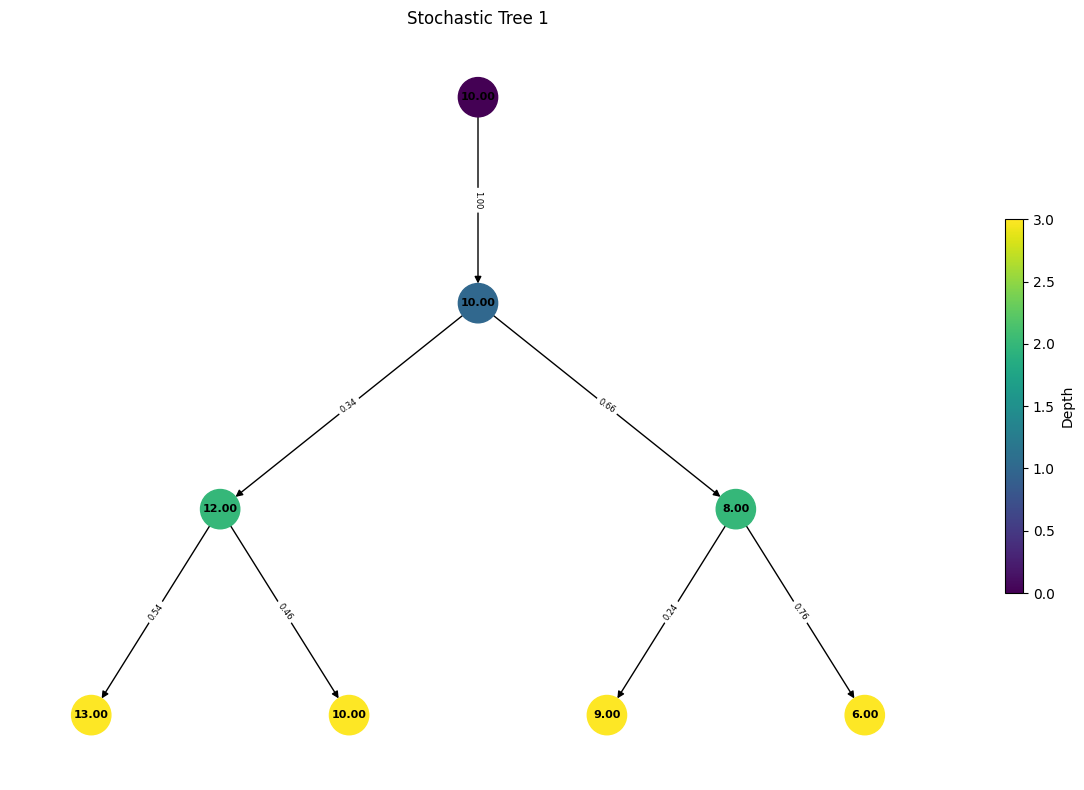

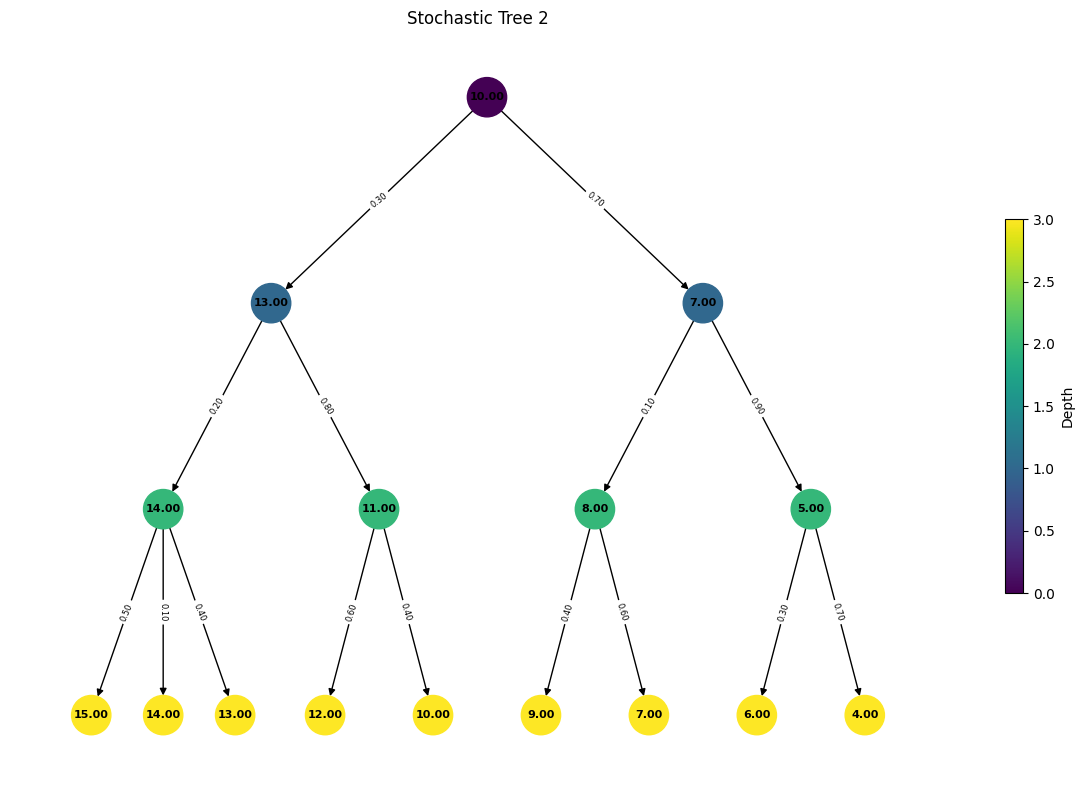


Random Stochastic Tree (Path and Weight Format):
Paths:
[[ 0.42472283 86.87307431 33.82596353]
 [ 0.42472283 86.87307431 92.06992966]
 [ 0.42472283 86.87307431 15.05397093]
 [ 0.42472283 18.32041186 80.99798013]
 [ 0.42472283 18.32041186 48.93694579]
 [ 0.42472283 18.32041186 76.18698042]]
Weights:
[0.01951154 0.12206277 0.35028247 0.25588651 0.12119465 0.13106206]

Depth of Random Stochastic Tree: 2


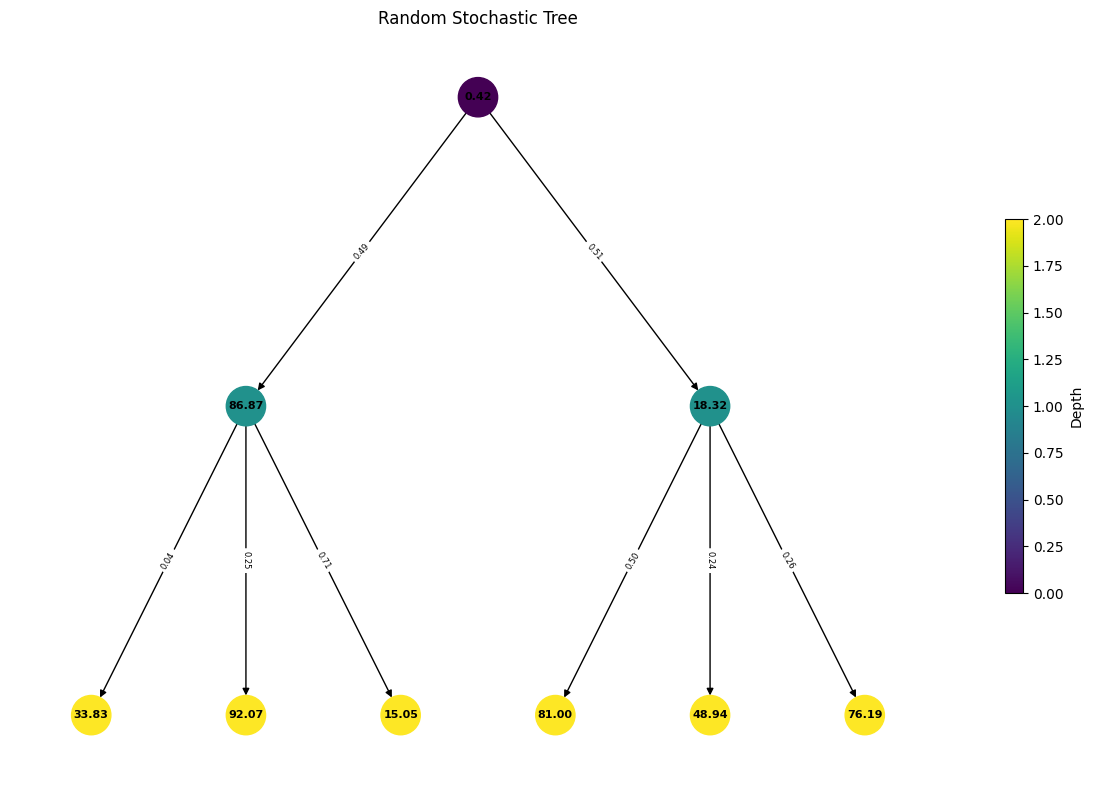

In [9]:
# Build both trees
tree_1_root = build_tree_1()
tree_2_root = build_tree_2()

# Save trees
save_tree(tree_1_root, 'tree_1.pkl')
save_tree(tree_2_root, 'tree_2.pkl')

# Load trees (optional, to demonstrate loading)
loaded_tree_1 = load_tree('tree_1.pkl')
loaded_tree_2 = load_tree('tree_2.pkl')

# Get sample paths and probabilities for Tree 1
paths_1, probs_1 = get_sample_paths(loaded_tree_1)
display_tree_data((paths_1, probs_1), "Stochastic Tree 1")

# Get sample paths and probabilities for Tree 2
paths_2, probs_2 = get_sample_paths(loaded_tree_2)
display_tree_data((paths_2, probs_2), "Stochastic Tree 2")

# Get depth of Tree 1
depth_1 = get_depth(loaded_tree_1)
print(f"\nDepth of Stochastic Tree 1: {depth_1}")

# Get depth of Tree 2
depth_2 = get_depth(loaded_tree_2)
print(f"Depth of Stochastic Tree 2: {depth_2}")

# Visualize the first tree
visualize_tree(loaded_tree_1, title="Stochastic Tree 1")

# Visualize the second tree
visualize_tree(loaded_tree_2, title="Stochastic Tree 2")

# Generate a random stochastic tree (optional)
random_tree = generate_stochastic_tree(depth=3, max_children=3, a=0, b=100)
paths_random, probs_random = get_sample_paths(random_tree)
display_tree_data((paths_random, probs_random), "Random Stochastic Tree")

depth_random = get_depth(random_tree)
print(f"\nDepth of Random Stochastic Tree: {depth_random}")

# Visualize the random tree
visualize_tree(random_tree, title="Random Stochastic Tree")

### STILL WORKING THERE!!!!!!!!!

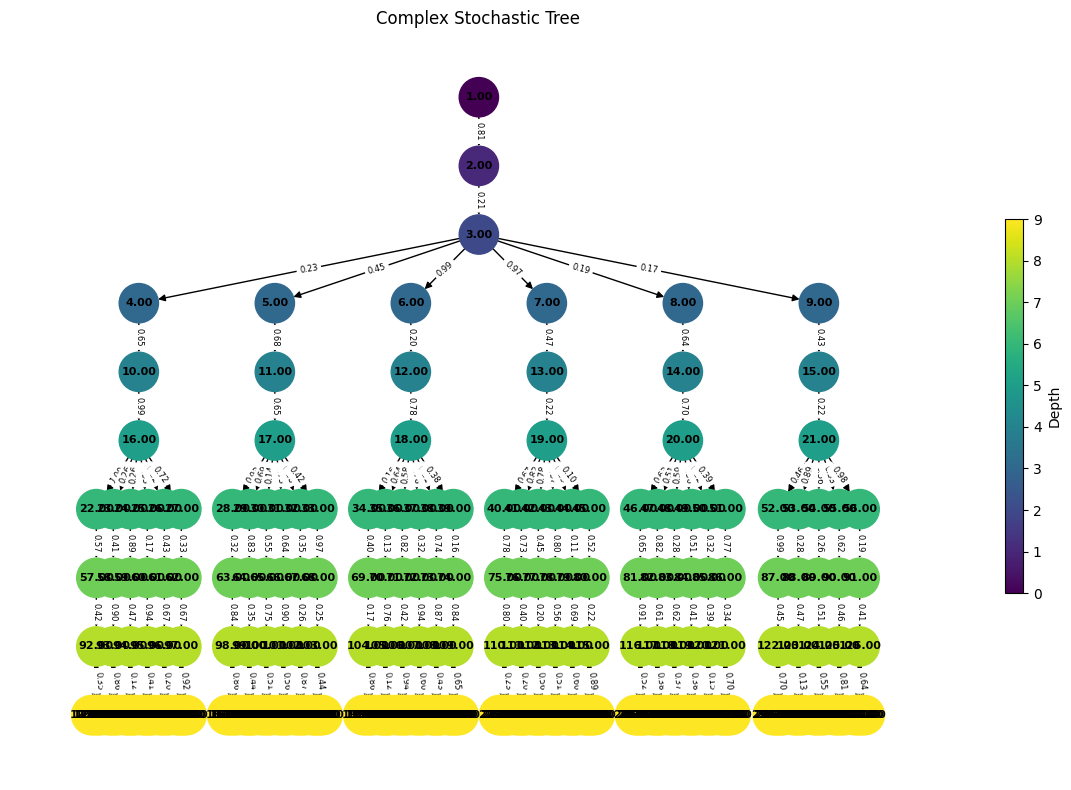

In [10]:
def generate_complex_tree(max_depth=9, volatile_depths={2, 5, 8}, volatile_children_range=(5, 6)):
    """
    Generates a complex stochastic tree with both deterministic and volatile branches.

    Parameters:
    - max_depth (int): The maximum depth of the tree (root is at depth 0).
    - volatile_depths (set of int): Depth levels at which nodes have multiple children.
    - volatile_children_range (tuple of int): The range (min, max) of children for volatile nodes.

    Returns:
    - TreeNode: Root node of the generated complex tree.
    """
    from collections import deque

    # Initialize the root node with value 1
    root = TreeNode(1)
    current_value = 2  # Start assigning integer values from 2

    # Queue for BFS traversal: (node, current_depth)
    queue = deque()
    queue.append((root, 0))

    while queue:
        current_node, depth = queue.popleft()

        if depth >= max_depth:
            continue  # Reached maximum depth, do not add children

        if depth in volatile_depths:
            # Volatile node: assign 5-6 children
            num_children = random.randint(*volatile_children_range)
        else:
            # Deterministic node: assign only one child
            num_children = 1

        for _ in range(num_children):
            # Create a new child node with the next integer value
            child_node = TreeNode(current_value)
            current_value += 1

            # Assign a random transition probability between 0.1 and 1.0
            probability = round(random.uniform(0.1, 1.0), 2)

            # Add the child to the current node
            current_node.add_child(child_node, probability)

            # Enqueue the child for further processing
            queue.append((child_node, depth + 1))

    return root
complex_tree = generate_complex_tree()
visualize_tree(complex_tree, title="Complex Stochastic Tree")